Implementing the parabola loss in the label free paper:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
N = 10
delta_t = 0.1
g = -9.8

In [3]:
A_mat = np.stack([
    [i * delta_t for i in range(1, N+1)],
    [1] * N
], axis=1)

In [4]:
A_mat.shape

(10, 2)

In [5]:
A_mat

array([[0.1, 1. ],
       [0.2, 1. ],
       [0.3, 1. ],
       [0.4, 1. ],
       [0.5, 1. ],
       [0.6, 1. ],
       [0.7, 1. ],
       [0.8, 1. ],
       [0.9, 1. ],
       [1. , 1. ]])

In [6]:
accel_mat = np.array([g * (i * delta_t) ** 2 for i in range(1, N+1)])

In [7]:
accel_mat

array([-0.098, -0.392, -0.882, -1.568, -2.45 , -3.528, -4.802, -6.272,
       -7.938, -9.8  ])

In [8]:
accel_mat = accel_mat.reshape(-1, 1)

In [9]:
accel_mat

array([[-0.098],
       [-0.392],
       [-0.882],
       [-1.568],
       [-2.45 ],
       [-3.528],
       [-4.802],
       [-6.272],
       [-7.938],
       [-9.8  ]])

In [10]:
F_mat = np.linalg.inv(A_mat.transpose() @ A_mat)

In [11]:
F_mat = A_mat @ F_mat @ A_mat.transpose()

In [12]:
F_mat.shape

(10, 10)

In [13]:
preds = np.random.uniform(size=(10, 1))

In [14]:
parabola = accel_mat + F_mat @ (preds - accel_mat)

In [15]:
parabola

array([[-0.73622394],
       [ 0.08082217],
       [ 0.70186829],
       [ 1.12691441],
       [ 1.35596052],
       [ 1.38900664],
       [ 1.22605275],
       [ 0.86709887],
       [ 0.31214499],
       [-0.4388089 ]])

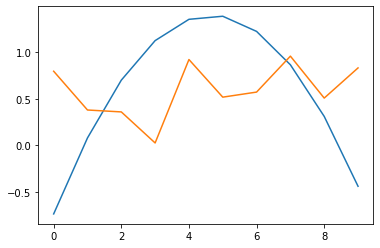

In [16]:
plt.plot(parabola)
plt.plot(preds)
plt.show()

Stringing the pieces into a loss function:

In [17]:
def parabola_loss(preds: np.ndarray):
    # preds should have shape (N, 1)
    
    N = len(preds)
    delta_t = 0.1
    g = -9.8

    # velocity and displacement terms mat
    vd_mat = np.stack([
        [i * delta_t for i in range(1, N+1)],
        [1] * N
    ], axis=1)

    accel_mat = np.array([g * (i * delta_t) ** 2 for i in range(1, N+1)])
    accel_mat = np.expand_dims(accel_mat, axis=1)

    F_mat = np.linalg.inv(A_mat.transpose() @ A_mat)
    F_mat = A_mat @ F_mat @ A_mat.transpose()

    parabola = accel_mat + F_mat @ (preds - accel_mat)

    return np.sum(np.abs(parabola - preds))

In [18]:
parabola_loss(np.random.uniform(size=(10, 1)))

6.11506850223698

In [19]:
preds = np.random.uniform(size=(10, 1))

In [20]:
%%timeit
parabola_loss(preds)

The slowest run took 5.14 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 141 µs per loop


The mat muls only need to be done once as long as the number of N and delta_t evaluated at every training step is the same.

In [21]:
def precompute_terms(N: int = 10, delta_t: float = 0.1, g = -9.8):
    # velocity and displacement terms mat
    vd_mat = np.stack([
        [i * delta_t for i in range(1, N+1)],
        [1] * N
    ], axis=1)

    accel_mat = np.array([g * (i * delta_t) ** 2 for i in range(1, N+1)])
    accel_mat = np.expand_dims(accel_mat, axis=1)

    F_mat = np.linalg.inv(accel_mat.transpose() @ accel_mat)
    F_mat = accel_mat @ F_mat @ accel_mat.transpose()

    return F_mat, accel_mat

In [22]:
F_mat, accel_mat = precompute_terms(N=10, delta_t=0.1)

In [23]:
def parabola_loss(preds: np.ndarray, F_mat, accel_mat):
    # preds should have shape (N, 1)
    parabola = accel_mat + F_mat @ (preds - accel_mat)
    return np.sum(np.abs(parabola - preds))

In [24]:
%%timeit
parabola_loss(preds, F_mat, accel_mat)

The slowest run took 17.18 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 29 µs per loop


Yeah that's better. 

Alright! Here we go.